# compile and postprocess subhalos from morphology data Connor constructed

In [1]:
import os
import numpy as np 
from astropy import table as aTable

In [2]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# load subhalo and morphy data in G, I, R, Y, Z bands

In [3]:
dat_dir = '/Users/chahah/data/frb_halos/'

morph_g = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_G.csv'))
morph_i = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_I.csv'))
morph_r = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_R.csv'))
morph_y = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Y.csv'))
morph_z = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Z.csv'))

subhalo = aTable.Table.read(os.path.join(dat_dir, 'Subhalos.csv'))

In [4]:
print('%i morphology' % len(morph_g))
print('%i subhalos' % len(subhalo))

36210 morphology
187978 subhalos


In [5]:
subhalo.columns

<TableColumns names=('dbID','SnapNum','SubfindID','SubhaloMassType_stars','SubhaloMassType_gas','SubhaloMassType_dm','SubhaloMassInRadType_stars','SubhaloMassInRadType_gas','SubhaloMassInRadType_dm','SubhaloMassInHalfRadType_stars','SubhaloMassInHalfRadType_gas','SubhaloMassInHalfRadType_dm','SubhaloHalfMassRadType_stars','SubhaloHalfMassRadType_gas','SubhaloHalfMassRadType_dm','SubhaloSFR','SubhaloSFRinRad','SubhaloSFRinHalfRad')>

# compile morphology

In [6]:
for morph in [morph_g, morph_i, morph_r, morph_y, morph_z]:
    morph['snapshot'] = [int(dbid.split('_')[1]) for dbid in morph['dbID'].data]
    morph['subhalo_id'] = [int(dbid.split('_')[2]) for dbid in morph['dbID'].data]
    morph['version'] = [dbid.split('_')[3] for dbid in morph['dbID'].data]

In [7]:
col_photo = ['Sersic_mag', 'Sersic_Reff', 'CAS_C', 'CAS_A', 'Sersic_dmag_m', 'Sersic_dmag_p']
col_subhalo = ['SubhaloMassType_stars']

In [8]:
for band, morph in zip(['g', 'i', 'r', 'y', 'z'], [morph_g, morph_i, morph_r, morph_y, morph_z]): 
    cols = morph.columns.copy()
    for k in cols: 
        if k in col_photo: 
            morph.rename_column(k, '%s_%s' % (band, k))
        elif k in ['snapshot', 'subhalo_id', 'version']: 
            pass
        else: 
            morph.remove_column(k)

In [9]:
for i, morph in enumerate([morph_g, morph_i, morph_r, morph_y, morph_z]): 
    mask = np.zeros(len(morph)).astype(bool)
    for k in morph.columns: 
        try: 
            mask = mask | morph[k].mask
        except AttributeError: 
            pass
        
    if i == 0: 
        morphs = morph.copy()
    else:        
        morphs = aTable.join(morphs, morph[~mask], keys=['snapshot', 'subhalo_id', 'version'], join_type='left')

In [10]:
mask = np.zeros(len(morphs)).astype(bool)
for k in morphs.columns: 
    try: 
        mask = mask | morphs[k].mask
    except AttributeError: 
        pass
morphs = morphs[~mask]

In [12]:
morphs.write(os.path.join(dat_dir, 'MorphSersic_HSC_combined.csv'), overwrite=True)

In [13]:
len(morphs)

35302

# match morphology to subhalos

In [17]:
subhalo['snapshot'] = [int(dbid.split('_')[0]) for dbid in subhalo['dbID'].data]
subhalo['subhalo_id'] = [int(dbid.split('_')[1]) for dbid in subhalo['dbID'].data]

In [18]:
combined = aTable.join(morphs, subhalo['snapshot', 'subhalo_id', 'SubhaloMassType_stars', 'SubhaloMassType_dm'], 
                       keys=['snapshot', 'subhalo_id'], join_type='left')

In [19]:
len(combined)

35302

In [20]:
combined[:10]

g_Sersic_Reff,g_Sersic_mag,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.25528,21.2298,2.99239,0.0938263,72,2,v1,4.16832,18.571,3.28954,0.126143,2.91195,19.6049,2.89179,0.0434264,3.30955,18.1209,3.28799,0.0380111,3.64525,18.2812,3.18919,0.0426677,11.6231,12.6887
3.26895,20.4683,3.7825,-0.00620702,72,2,v2,2.10128,18.1837,3.98046,0.0408436,2.1451,18.9516,4.27905,0.0405177,2.18384,17.6501,4.17823,0.0320972,2.28699,17.8094,3.98046,0.0194969,11.6231,12.6887
0.562615,20.5945,3.10076,-0.0095417,72,3,v3,0.509527,18.4316,3.1758,0.00177842,0.530891,19.0818,3.04872,-0.000310977,0.499392,17.9462,3.35912,0.0199723,0.500237,18.1175,3.23204,0.00302388,11.4424,11.3403
0.583362,20.5666,3.01071,0.035001,72,3,v2,0.549231,18.3873,3.23204,0.0308623,0.593303,19.0462,3.15005,0.0248321,0.556779,17.8952,3.28543,0.027298,0.531199,18.0856,3.28543,0.0281832,11.4424,11.3403
0.57194,20.5431,3.01071,-0.00489519,72,3,v0,0.528144,18.3593,3.35912,0.027935,0.560794,18.9921,3.01071,0.0236374,0.520494,17.8699,3.01071,0.0109326,0.512271,18.0553,3.35912,0.0285452,11.4424,11.3403
0.563427,20.5404,3.15005,0.0210087,72,3,v1,0.550891,18.2742,3.5438,0.0845488,0.595945,18.9195,3.09374,0.0172843,0.515094,17.784,3.60266,0.0564378,0.507325,17.9669,3.78491,0.0712816,11.4424,11.3403
3.47313,21.3465,2.67507,0.0619618,72,4,v1,3.13199,19.7905,2.67009,0.137574,3.39976,20.2478,2.57322,0.0694838,3.11344,19.2919,2.56787,0.109682,3.03412,19.4497,2.67142,0.0918339,10.8639,11.933
5.72129,20.1663,3.275,0.325276,72,4,v0,15.7643,18.2439,3.24078,0.0502008,26.2531,18.3448,2.95473,0.0514431,12.7927,18.1647,2.94577,0.428659,11.6482,18.2194,3.14157,0.0376797,10.8639,11.933
0.706867,22.0049,2.89067,0.00579519,72,5,v3,0.80246,19.4973,3.26496,0.0188985,0.663487,20.3603,2.92808,-0.0082719,0.788507,18.9834,3.31204,-0.0132748,0.709298,19.2311,3.01869,0.000409997,10.9867,11.6897


In [21]:
combined = combined[combined['SubhaloMassType_dm'] > 0]

In [22]:
cols = list(combined.dtype.names)
cols.remove('snapshot')
cols.remove('subhalo_id')
cols.remove('version')

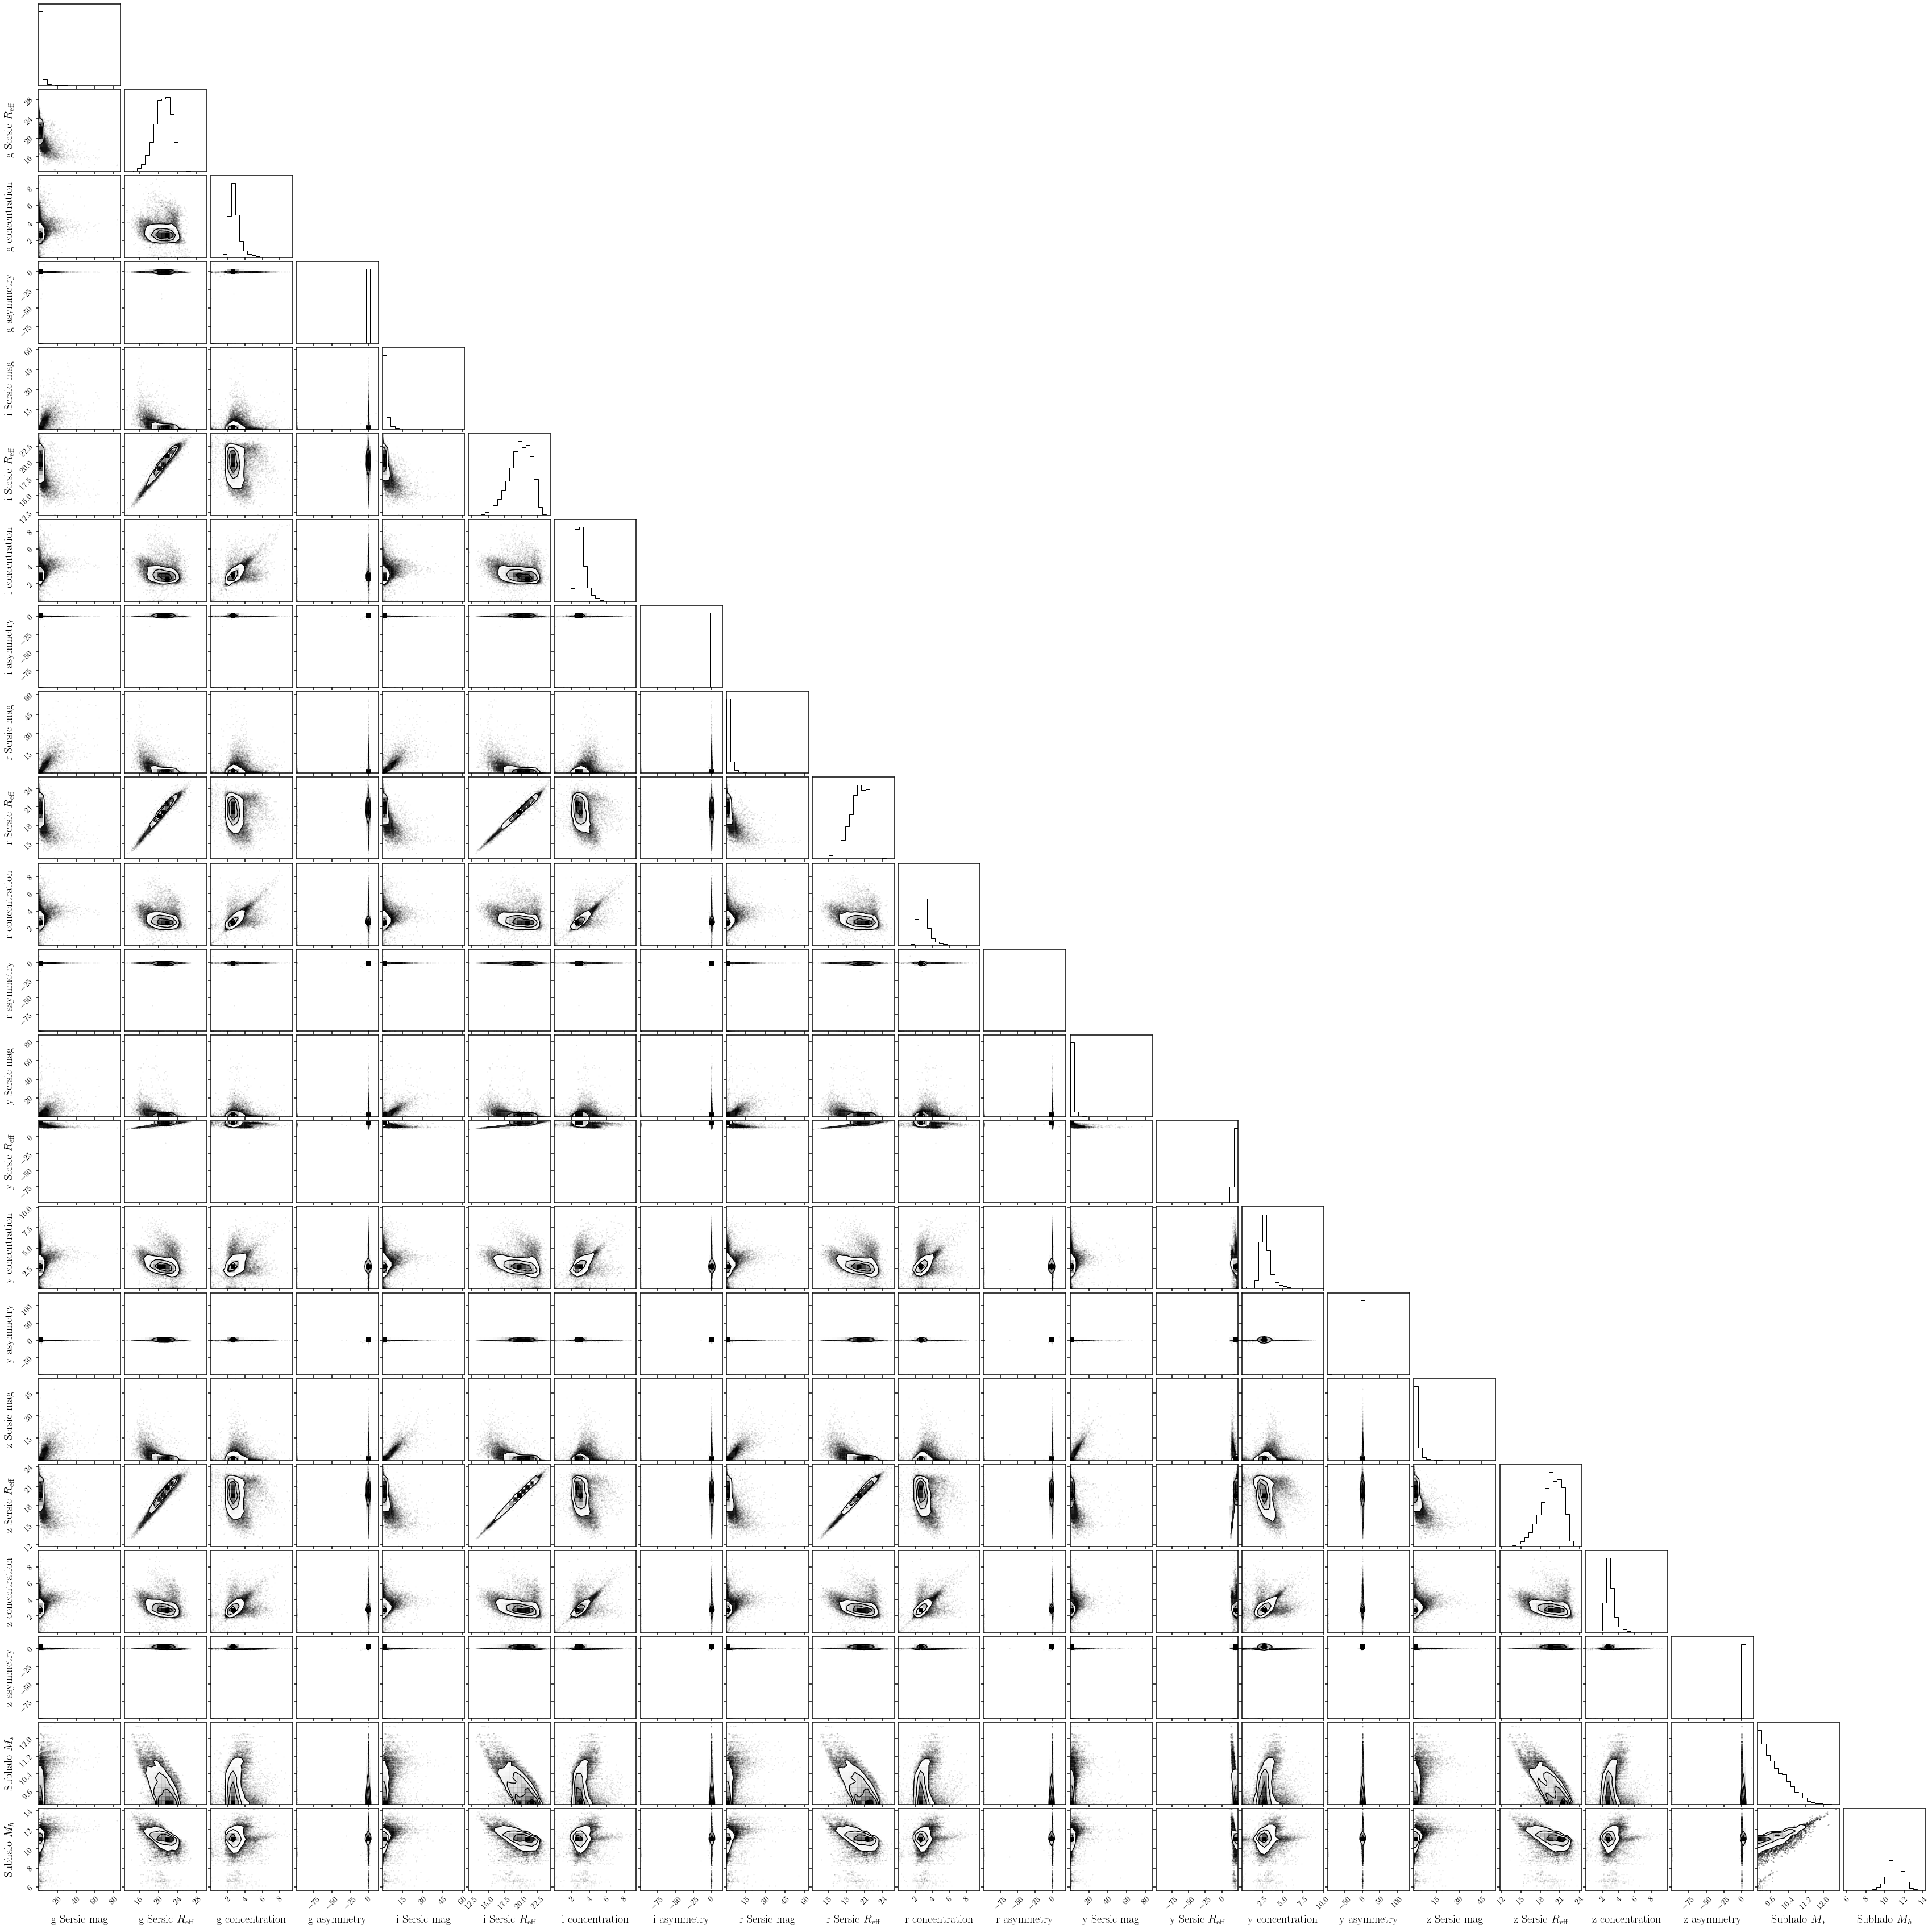

In [23]:
fig = DFM.corner(np.array([np.array(combined[col].data) for col in cols]).T, 
                 labels=['g Sersic mag', r'g Sersic $R_{\rm eff}$', r'g concentration', r'g asymmetry', 
                         'i Sersic mag', r'i Sersic $R_{\rm eff}$', r'i concentration', r'i asymmetry', 
                         'r Sersic mag', r'r Sersic $R_{\rm eff}$', r'r concentration', r'r asymmetry', 
                         'y Sersic mag', r'y Sersic $R_{\rm eff}$', r'y concentration', r'y asymmetry', 
                         'z Sersic mag', r'z Sersic $R_{\rm eff}$', r'z concentration', r'z asymmetry', 
                         r'Subhalo $M_*$', r'Subhalo $M_h$'], 
                 label_kwargs={'fontsize': 20})

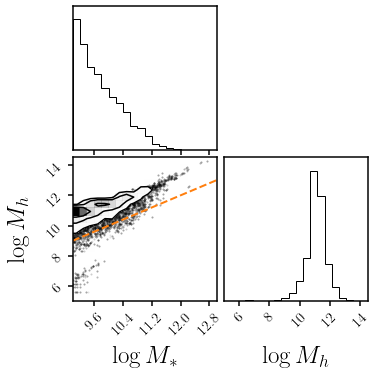

In [43]:
fig = DFM.corner(np.array([np.array(combined[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T, 
               range=[(9., 13.), (5., 14.5)],
              labels=[r'$\log M_*$', r'$\log M_h$'],
              label_kwargs={'fontsize': 25})
fig.axes[2].plot([9., 13.], [9., 13.], c='C1', ls='--', linewidth=2)

In [24]:
combined[:5]

g_Sersic_Reff,g_Sersic_mag,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.25528,21.2298,2.99239,0.0938263,72,2,v1,4.16832,18.571,3.28954,0.126143,2.91195,19.6049,2.89179,0.0434264,3.30955,18.1209,3.28799,0.0380111,3.64525,18.2812,3.18919,0.0426677,11.6231,12.6887
3.26895,20.4683,3.7825,-0.00620702,72,2,v2,2.10128,18.1837,3.98046,0.0408436,2.1451,18.9516,4.27905,0.0405177,2.18384,17.6501,4.17823,0.0320972,2.28699,17.8094,3.98046,0.0194969,11.6231,12.6887
0.562615,20.5945,3.10076,-0.0095417,72,3,v3,0.509527,18.4316,3.1758,0.00177842,0.530891,19.0818,3.04872,-0.000310977,0.499392,17.9462,3.35912,0.0199723,0.500237,18.1175,3.23204,0.00302388,11.4424,11.3403
0.583362,20.5666,3.01071,0.035001,72,3,v2,0.549231,18.3873,3.23204,0.0308623,0.593303,19.0462,3.15005,0.0248321,0.556779,17.8952,3.28543,0.027298,0.531199,18.0856,3.28543,0.0281832,11.4424,11.3403
0.57194,20.5431,3.01071,-0.00489519,72,3,v0,0.528144,18.3593,3.35912,0.027935,0.560794,18.9921,3.01071,0.0236374,0.520494,17.8699,3.01071,0.0109326,0.512271,18.0553,3.35912,0.0285452,11.4424,11.3403


In [25]:
combined.write('/Users/chahah/data/frb_halos/subhalos_morph.csv', overwrite=True)